# Loading and Viewing BubbleML

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import torch

c:\Users\Harsh\anaconda3\envs\bubble_sciml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create an h5py file
In this case, we are using the simulation run with a wall temperature of 100 degrees Celsius.
The simulation file includes a list of keys:
  1. `dfun` is a signed distance function from the bubbble interface
  2. `pressure` is the pressure gradient
  3. `temperature` is the temperature map
  4. `velx` is the velocity in the x direction
  5. `vely` is the velocity in the y direction
  6. `x` and `y `are coordinate grids
  7. `int/real-runtime-params` are metadata associated with the simulation run.
     This includes things like the Reynold's number, simulation dimensions, etc.

In [7]:
twall_100 = h5py.File('Twall-100.hdf5', 'r')
for idx, key in enumerate(twall_100.keys()):
    print(f'{idx + 1}. {key}')

1. dfun
2. int-runtime-params
3. pressure
4. real-runtime-params
5. temperature
6. velx
7. vely
8. x
9. y


### Tensor sizes
Each tensor is laid out [T x Y x X] (time, y-direction, x-direction). In this case, there are 200 time steps and the domain resolution is 48x48

In [8]:
[time_res, y_res, x_res] = twall_100['temperature'][:].shape

print(f'# Timesteps: {time_res}')
print(f'Domain resolution: {y_res} x {x_res}')

# Timesteps: 201
Domain resolution: 48 x 48


### Visualizing the different fields
The data can be easily loaded into numpy (or torch, tensorflow, etc) arrays and visualized with matplotlib.

(201, 48, 48)
torch.Size([201, 48, 48])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

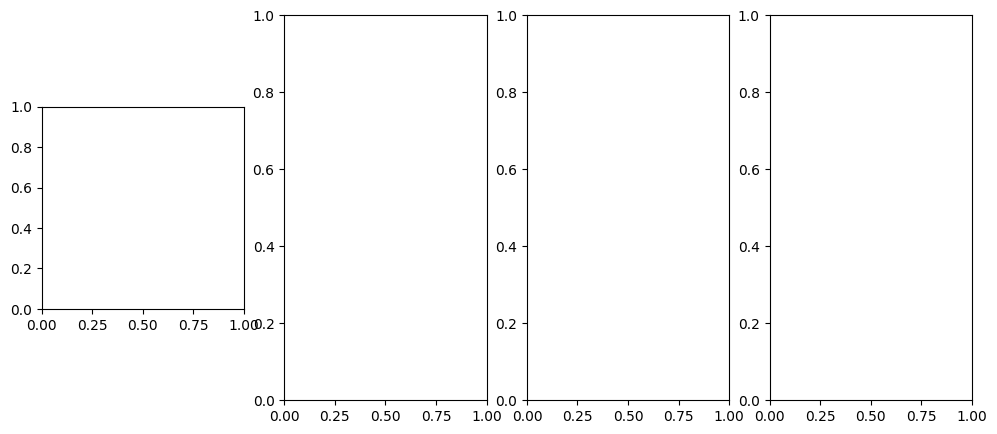

In [19]:
temp = twall_100['temperature'][:]
print(temp.shape)
velx = torch.from_numpy(twall_100['velx'][:]).cuda()
vely = torch.from_numpy(twall_100['vely'][:]).cuda()
pres = torch.from_numpy(twall_100['pressure'][:]).cuda()
print(pres.shape)
dfun = torch.from_numpy(twall_100['dfun'][:]).cuda()

# compute the velocity magnitude
mag = torch.sqrt(velx**2 + vely**2)

# plot the 50-th timestep for each variable
fig, ax = plt.subplots(1, 4, figsize=(12, 5))

data = {
    'Temperature': velx[50],
    'Velocity Mag.': mag[50],
    'Pressure Grad.': pres[50],
    'Distance Func.': dfun[50]
}

for idx, (key, im) in enumerate(data.items()):
    im = ax[idx].imshow(torch.flipud(im))
    fig.colorbar(im, ax=ax[idx], shrink=0.5)
    ax[idx].set_title(key)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])





In [43]:
def trim_ends(field, dim):
        for d in dim:
            field = torch.narrow(field, d, 0, field.shape[d] - 1)
    
        return field

def compute_gradient(vel, resolution):
    grad = []
    
    for (i,res) in enumerate(resolution):
        dim = [-len(resolution)+((i+k)%len(resolution)) for k in range(1,len(resolution),1)]
        if i == 0:
            grad.append(trim_ends(compute_derivative(vel, res, -len(resolution)+i, -1), dim).unsqueeze(0))
        else:
            grad.append(trim_ends(compute_derivative(vel, res, -len(resolution)+i, 1), dim).unsqueeze(0))

    for i in grad:
        print(i.shape)
    grad = torch.cat(grad, dim = 0)
    
    return grad

    
def compute_derivative(field, resolution, dim, direction = 1):
    N = field.shape
    
    resh = [1] * len(N)
    resh[dim] = N[dim]

    reps = list(N)
    reps[dim] = 1
    
    k = (torch.fft.fftfreq(N[dim], resolution).reshape(resh).repeat(reps)*resolution).cuda()

    field_derivative = torch.fft.fft(field, dim = dim)

    if direction == 1:
        field_derivative = field_derivative * (torch.exp(2j * np.pi * k) - 1)
    else:
        field_derivative = field_derivative * (1 - torch.exp(-2j * np.pi * k))
    
    field_derivative = torch.narrow(field_derivative, dim, 0, N[dim]//2 + 1)
    field_derivative = torch.fft.irfft(field_derivative, dim = dim)

    if direction == 1:
        field_derivative = torch.narrow(field_derivative, dim, 0, N[dim]-2)/resolution
    else:
        print(field_derivative.shape)
        field_derivative = torch.narrow(field_derivative, dim, 1, N[dim]-2)/resolution

    return field_derivative



In [44]:


combined_magnitude = torch.sqrt(velx**2 + vely**2)

grad_mag = compute_gradient(combined_magnitude, [1, .8, .8])

# du_dt = grad_mag[0]





fig, ax = plt.subplots(1, 4, figsize=(12, 5))

data = {
    'Vel Mag': combined_magnitude[50],
    'Time Dir': grad_mag[50],
    'Pressure Grad.': pres[50],
    'Distance Func.': dfun[50]
}

for idx, (key, im) in enumerate(data.items()):
    im = ax[idx].imshow(np.flipud(im))
    fig.colorbar(im, ax=ax[idx], shrink=0.5)
    ax[idx].set_title(key)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])


torch.Size([200, 48, 48])
torch.Size([1, 199, 47, 47])
torch.Size([1, 200, 46, 47])
torch.Size([1, 200, 47, 46])


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 199 but got size 200 for tensor number 1 in the list.

### Visualizing different timesteps
By progressively indexing along the time axis (dimension 0), we are able to see the progression as it leaves the heater surface.

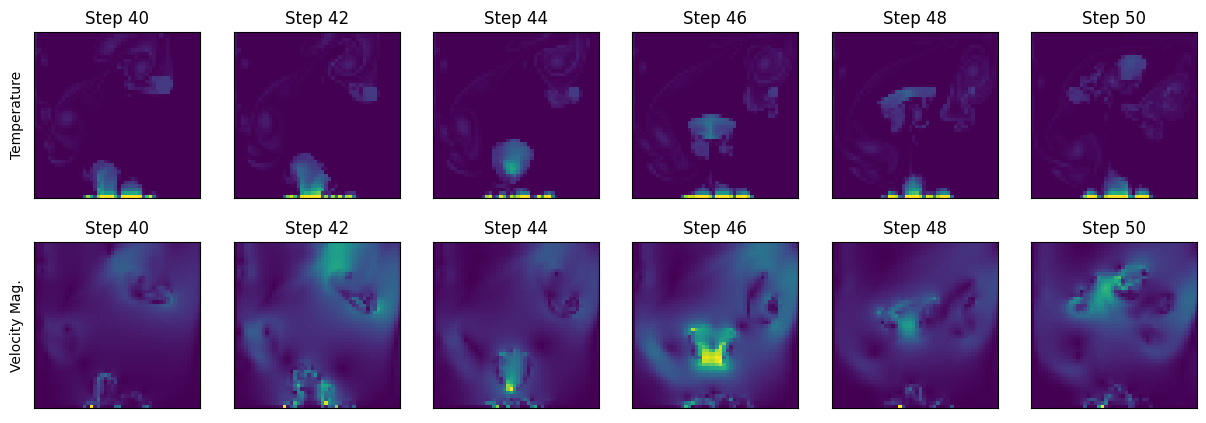

In [5]:
temp = twall_100['temperature'][:]
mag = np.sqrt(twall_100['velx'][:]**2 + twall_100['vely'][:]**2)

timesteps = range(40, 52, 2)

fig, ax = plt.subplots(2, len(timesteps), figsize=(15, 5))

for idx, step in enumerate(timesteps):
    ax[0, idx].imshow(np.flipud(temp[step]))
    ax[1, idx].imshow(np.flipud(mag[step]))
    for row in range(2):
        ax[row, idx].set_title(f'Step {step}')
        ax[row, idx].set_xticks([])
        ax[row, idx].set_yticks([])
    ax[0,0].set_ylabel('Temperature')
    ax[1,0].set_ylabel('Velocity Mag.')

### Using dfun
dfun is a *signed distance function* to the liquid-vapor interfaces. 
dfun > 0 means the point is in vapor, dfun < 0 means the point is in liquid. It is also a convenient way to identify the bubble interfaces. 

The function `get_interface_mask` matches the function used in the simulations. [See equation (8)](https://doi.org/10.1016/j.ijmultiphaseflow.2019.103099). We use numba to jit compile this function for performance.

In [6]:
@nb.njit
def get_interface_mask(dgrid):
    r""" heavy-side function to determine the bubble interfaces
    """
    interface = np.zeros(dgrid.shape).astype(np.bool_)
    [rows, cols] = dgrid.shape
    for i in range(rows):
        for j in range(cols):
            adj = ((i < rows - 1 and dgrid[i][j] * dgrid[i+1, j  ] <= 0) or
                   (i > 0 and dgrid[i][j] * dgrid[i-1, j  ] <= 0) or
                   (j < cols - 1 and dgrid[i][j] * dgrid[i,   j+1] <= 0) or
                   (j > 0 and dgrid[i][j] * dgrid[i,   j-1] <= 0))
            interface[i][j] = adj
    return interface

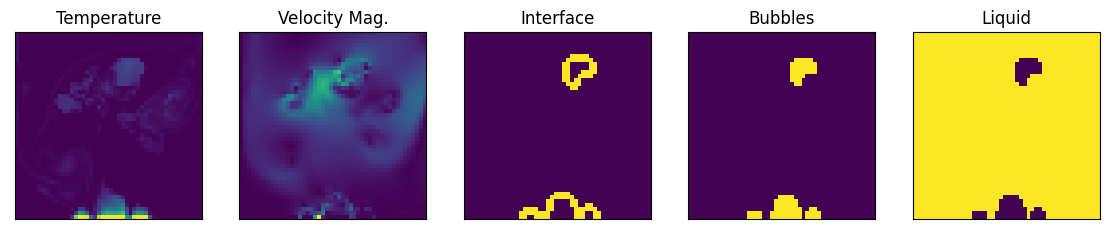

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(14, 5))

bubbles = dfun[50] >= 0  # vapor phase has non-negative distance.
liquid = dfun[50] < 0    # Liquid has negative distance.
interface = get_interface_mask(dfun[50])

data = {
    'Temperature': temp[50],
    'Velocity Mag.': mag[50],
    'Interface': interface,
    'Bubbles': bubbles,
    'Liquid': liquid
}

for idx, (key, im) in enumerate(data.items()):
    ax[idx].imshow(np.flipud(im))
    ax[idx].set_title(key)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])

### Accessing the metadata

There is a lot of metadata associated with each simulation. Pointers to some of the important metadata is listed in our [dataset documentation](https://github.com/HPCForge/BubbleML/blob/main/bubbleml_data/DOCS.md). The metadata is stored as a numpy array of tuples. Each tuple contains an array of bytes (the key) and a float (the value). The metadata stores critical information for the simulation. Some of these values (like the reynolds nunmber) will be necessary for training physics informed models.

In [8]:
real_runtime_params = twall_100['real-runtime-params'][:]
key0, val0 = real_runtime_params[0]

print(f'Metadata size: {real_runtime_params.shape}')
print(f'Key type: {type(key0)}')
print(f'Val type: {type(val0)}')

def key_to_str(key):
    # convert byte string to a standard python utf-8 string.
    return key.decode('utf-8').strip()

# Convert to a dict of (string, float64)
runtime_param_dict = dict([(key_to_str(key), val) for (key, val) in real_runtime_params])

# print the reynolds number
inv_reynolds = runtime_param_dict['ins_invreynolds']
print(f'Reynolds Number: {1 / inv_reynolds}')

Metadata size: (109,)
Key type: <class 'numpy.bytes_'>
Val type: <class 'numpy.float64'>
Reynolds Number: 238.0952380952381


### Getting the Domain Size
The simulations in BubbleML are not all the same size. So, it can be beneficial to know how to access the true spatial dimensions. 
Here, we read the xy-extents from the metadata and set them as axis ticks on an image.

x extents: -6.0, 6.0
y extents: 0.0, 12.0


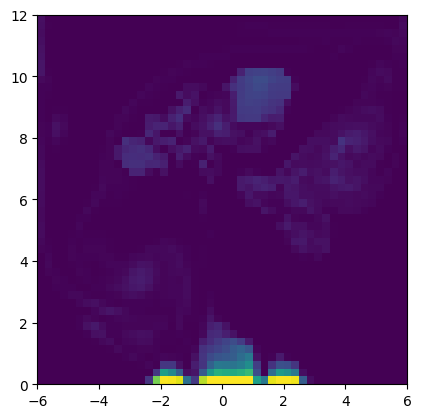

In [9]:
xmin, xmax = runtime_param_dict['xmin'], runtime_param_dict['xmax']
ymin, ymax = runtime_param_dict['ymin'], runtime_param_dict['ymax']

print(f'x extents: {xmin}, {xmax}')
print(f'y extents: {ymin}, {ymax}')

plt.imshow(np.flipud(temp[50]), extent=[xmin,xmax,ymin,ymax])
plt.show()